# Import Basic Things

In [29]:
import json
import random
import math
import nltk
import numpy as np
import itertools

from processor import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data.dataloader import default_collate

# Parameters and constants

In [30]:
ALL_DATA = 'result.json'

EXIT_AFTER_TRAIN = True
REVERSE_MODE = True
SAVE_ANYWAY = False # True False

BASE_FILE_NAME = None
NEW_MODEL_FILE_NAME = 'fa2tg_more.pt' # '02_tg2fa_more.pt'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

START_TOKEN = '<s>'
PAD_TOKEN = '<p>'
END_TOKEN = '</s>'

SAMET_REPEAT_TIMES = 1 # 20 1

CLIP = 1 
ENC_EMB_DIM = 64 
DEC_EMB_DIM = 64
ENC_HID_DIM = 512
DEC_HID_DIM = 512 
ENC_DROPOUT = 0.2 # 0.7 0.2
DEC_DROPOUT = 0.2 # 0.7 0.2
TRAINING_TEACHER_FORCING_RATIO = 0.1 # 0.8 0.1

LR = 1e-5 # 5e-4 1e-5
L1_REGULARIZATION = 0
L2_REGULARIZATION = 0.00025
LR_DECAY_RATE = 0.97
LR_DECAY_STEPS = 1

BATCH_SIZE = 32
EPOCHS = 800

# Import dataset

In [31]:
# reverse=True -> FA to TG
# reverse=False -> TG to FA
class TransliterateDataset(Dataset):
    def __init__(self, scr_word, trg_words, src_tokens_list, trg_tokens_list, reverse=False):
        src_words_ids = map(self.__cretate_mapper(src_tokens_list), scr_word)
        trg_words_ids = map(self.__cretate_mapper(trg_tokens_list), trg_words)
        
        if reverse:
            self.__rows = list(zip(trg_words_ids, src_words_ids))
            self.__both_tokens_list = trg_tokens_list, src_tokens_list
        else:
            self.__rows = list(zip(src_words_ids, trg_words_ids))
            self.__both_tokens_list = src_tokens_list, trg_tokens_list
        
    def __len__(self):
        return len(self.__rows)
    
    def __getitem__(self, idx):
        return self.__rows[idx]

        
    def __cretate_mapper(self, tokens_list: list):
        _map = {}
        
        for idx, word in enumerate(tokens_list):
            _map[word] = idx
            
        def map_to_ids(word):
            base = [_map[c] for c in [START_TOKEN] + list(word) + [END_TOKEN]]
#             pad = [_map[PAD_TOKEN]] * (MAX_LENGTH - len(base))
            return base, len(base)
        
        return map_to_ids
    
    def get_both_tokens_list(self):
        return self.__both_tokens_list
        

In [32]:
# def __create_tokens_list(self, words):
#     chars = set()
#     for word in words:
#         chars |= set(word)
#     return [START_TOKEN, END_TOKEN, PAD_TOKEN] + list(chars)

In [33]:
with open('tg_tokens', 'r') as f:
    tg_tokens = json.loads(f.read())
with open('fa_tokens', 'r') as f:
    fa_tokens = json.loads(f.read())

In [34]:
def read_vajeju_data(file_name):
    tg_words = []
    fa_words = []

    with open(file_name, 'r') as f:
        data = json.loads(f.read())

    for row in data.values():
        if row['tg'] != '' and row['fa'] != '':
            if '3' in row['fa'] or '/' in row['fa'] or '(' in row['fa'] or '-' in row['fa']:
                continue
            tg_words.append(tg_preprocess(row['tg']))
            fa_words.append(fa_preprocess(row['fa']))
    return tg_words, fa_words

tg_words, fa_words = read_vajeju_data(ALL_DATA)
# tg_words2, fa_words2 = tuple(zip(*get_samet_pairs(50)))

all_dataset = TransliterateDataset(tg_words, fa_words, tg_tokens, fa_tokens, reverse=REVERSE_MODE)

# Split dataset into the train, test, cv

In [35]:
lengths = [int(len(all_dataset)*frac) for frac in (0.9, 0.05)]
lengths.append(len(all_dataset) - sum(lengths))
_train_dataset, _test_dataset, _cv_dataset = random_split(all_dataset, lengths, generator=torch.Generator().manual_seed(42))
if SAMET_REPEAT_TIMES > 0:
    tg_words_samet, fa_words_samet = tuple(zip(*get_samet_pairs(SAMET_REPEAT_TIMES)))
    samet_dataset = TransliterateDataset(tg_words_samet, fa_words_samet, tg_tokens, fa_tokens, reverse=REVERSE_MODE)
    _train_dataset = list(itertools.chain(_train_dataset, samet_dataset))

# Batchify datasets

In [36]:
from torch.nn.utils.rnn import pad_sequence
def custom_collate_fn(rows):
    batch_sorted = sorted(rows, key=lambda x: x[0][1],reverse=True)
    
    max_length_src = batch_sorted[0][0][1]
    max_length_trg = max([x[1][1] for x in batch_sorted])
    
    src, trg = all_dataset.get_both_tokens_list()
    src_pad = src.index(PAD_TOKEN)
    trg_pad = trg.index(PAD_TOKEN)
    
    for idx, ((src, l_src), (trg, l_trg)) in enumerate(batch_sorted):
        pad_src = [src_pad] * (max_length_src - l_src)
        pad_trg = [trg_pad] * (max_length_trg - l_trg)
        batch_sorted[idx] = torch.tensor(src + pad_src).to(DEVICE), l_src, torch.tensor(trg + pad_trg).to(DEVICE), l_trg
        
    return default_collate(batch_sorted)

train_dataset = DataLoader(_train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
test_dataset = DataLoader(_test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
cv_dataset = DataLoader(_cv_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [38]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [39]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [40]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]

        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

In [41]:
SRC, TRG = all_dataset.get_both_tokens_list()

INPUT_DIM = len(SRC)
OUTPUT_DIM = len(TRG)
SRC_PAD_IDX = SRC.index(PAD_TOKEN)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, DEVICE).to(DEVICE)

Then, we initialize the model parameters.

In [42]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(38, 64)
    (rnn): GRU(64, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(40, 64)
    (rnn): GRU(1088, 512)
    (fc_out): Linear(in_features=1600, out_features=40, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,617,576 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [44]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=L2_REGULARIZATION)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_DECAY_STEPS, gamma=LR_DECAY_RATE)

In [45]:
TRG_PAD_IDX = TRG.index(PAD_TOKEN)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [46]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len, trg, _ = batch
        
        src = torch.transpose(src, 0, 1)
        trg = torch.transpose(trg, 0, 1)

        optimizer.zero_grad()
        
        output = model(src, src_len, trg, TRAINING_TEACHER_FORCING_RATIO)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        if L1_REGULARIZATION != 0:
            L1_reg = torch.tensor(0., requires_grad=True)

            for name, param in model.named_parameters():
                if 'weight' in name:
                    L1_reg = L1_reg + torch.norm(param, 1)

            loss = loss + L1_REGULARIZATION * L1_reg
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        
        epoch_loss += loss.item()
        
    scheduler.step()
    
    return epoch_loss / len(iterator)

In [47]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len, trg, _ = batch

            src = torch.transpose(src, 0, 1)
            trg = torch.transpose(trg, 0, 1)


            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
if BASE_FILE_NAME is not None:
    model.load_state_dict(torch.load(BASE_FILE_NAME))

The penultimate step is to train our model. Notice how it takes almost half the time as our model without the improvements added in this notebook.

In [50]:
# import time

# best_valid_loss = float('inf')

# for epoch in range(EPOCHS):
    
#     start_time = time.time()
    
#     train_loss = train(model, train_dataset, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, cv_dataset, criterion)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), NEW_MODEL_FILE_NAME)
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'LR is: {optimizer.param_groups[0]["lr"]}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
# if EXIT_AFTER_TRAIN:
#     exit()

Finally, we load the parameters from our best validation loss and get our results on the test set.

We get the improved test perplexity whilst almost being twice as fast!

In [51]:
model.load_state_dict(torch.load(NEW_MODEL_FILE_NAME, map_location=DEVICE))

test_loss = evaluate(model, test_dataset, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.505 | Test PPL:   1.657 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [52]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    tokens = sentence
        
    src_indexes = [src_field.index(token) for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.index(START_TOKEN)]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.index(END_TOKEN):
            break
    
    trg_tokens = [trg_field[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [53]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + sentence
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [54]:
def predict_and_draw(src, trg):
    translation, attention = translate_sentence(src, SRC, TRG, model, DEVICE)
    print(f'src = {"".join(src)}')
    print(f'trg = {"".join(trg[1:])}')
    print(f'prd = {"".join(translation)}')
    print(f'trg_array = {trg[1:]}')
    print(f'prd_array = {translation}')
    display_attention(src, translation, attention)
    
def predict_and_draw_by_dataset(inp):
    (src, _), (trg, _) = inp
    src = [SRC[idx] for idx in src]
    trg = [TRG[idx] for idx in trg]
    predict_and_draw(src, trg)

src = <s>قاضی‌القضاتی</s>
trg = қозиюлқузотӣ</s>
prd = қозиллқузотӣ</s>
trg_array = ['қ', 'о', 'з', 'и', 'ю', 'л', 'қ', 'у', 'з', 'о', 'т', 'ӣ', '</s>']
prd_array = ['қ', 'о', 'з', 'и', 'л', 'л', 'қ', 'у', 'з', 'о', 'т', 'ӣ', '</s>']


E:\Python Venv\mfi\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
E:\Python Venv\mfi\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


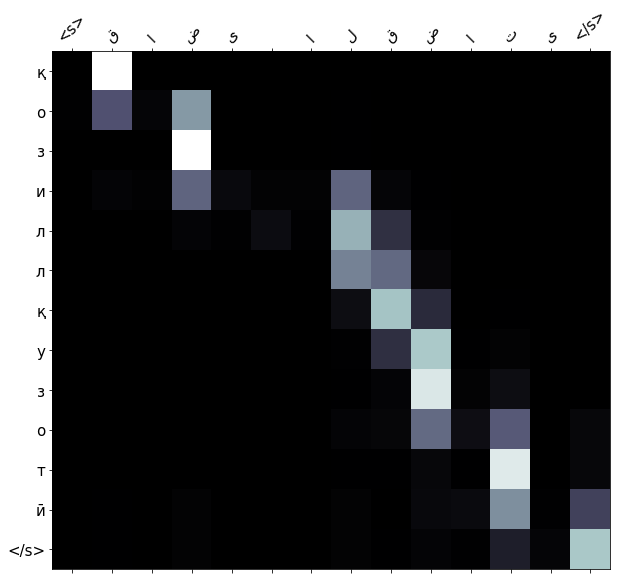

In [57]:
dataset = _test_dataset
example_idx = 240
predict_and_draw_by_dataset(dataset[example_idx])

## Evaluation

In [58]:
def compute_edit_distances(dataset):
    edit_distances = np.zeros(len(dataset))
    for i, inp in enumerate(dataset):
        (src, _), (trg, _) = inp
        src = [SRC[idx] for idx in src]
        trg = [TRG[idx] for idx in trg]
        translation, attention = translate_sentence(src, SRC, TRG, model, DEVICE)
        edit_distance = nltk.edit_distance("".join(translation), "".join(trg[1:]))
        edit_distances[i] = edit_distance
    return edit_distances

def report_results(dataset, edit_distances):
    total_data = len(dataset)
    thresholds = [0, 1, 2, 3, 4, 5]

    for t in thresholds:
        accuracy = (edit_distances <= t).sum() / total_data
        print('Accuracy (Edit distance <= {}): {}'.format(t, accuracy))

    print()
    print('Average edit distance: {}'.format(edit_distances.mean()))

In [59]:
test_edit_distances = compute_edit_distances(_test_dataset)

print('----------------------------------')
print('Test Dataset Results')
report_results(_test_dataset, test_edit_distances)

----------------------------------
Test Dataset Results
Accuracy (Edit distance <= 0): 0.647231543624161
Accuracy (Edit distance <= 1): 0.8557046979865772
Accuracy (Edit distance <= 2): 0.9467281879194631
Accuracy (Edit distance <= 3): 0.977768456375839
Accuracy (Edit distance <= 4): 0.9899328859060402
Accuracy (Edit distance <= 5): 0.9937080536912751

Average edit distance: 0.6052852348993288
